In [1]:
import numpy as np

class Counter(dict):
    def __init__(self, include_zeros = False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.top_three_list = []
        self.include_zeros = include_zeros
    
    def increment(self, item, delta = 1):
        new_val = delta + self.pop(item, 0)
        if new_val > 0:
            self[item] = new_val
        if self.include_zeros:
            self.update_top_three(item, new_val)
        else:
            self.update_top_three_no_zero(item, new_val)
    
    def update_top_three(self, item, value):
        counter = 0
        ## check if the key already exists in the top-three and update its value if it does
        for (k, v) in self.top_three_list:
            if item == k:
                counter += 1
                self.top_three_list.remove((k, v))
                self.top_three_list.append((k, value))
                self.top_three_list.sort(key=lambda x: x[1], reverse=True)
        ## check if there is space first [will always be space because we shorten list to three in final step], then check that the key does not already exist, and if so append it to the list
        if len(self.top_three_list) < 4:
            if counter == 0:
                self.top_three_list.append((item, value))
                self.top_three_list.sort(key=lambda x: x[1], reverse=True)
        ## take only top three of the elements of the list; and return only the values not the keys (i.e. the counts)
        self.top_three()

    def update_top_three_no_zero(self, item, value):
        if item != 0:
            counter = 0
            ## check if the key already exists in the top-three and update its value if it does
            for (k, v) in self.top_three_list:
                if item == k:
                    counter += 1
                    self.top_three_list.remove((k, v))
                    self.top_three_list.append((k, value))
                    self.top_three_list.sort(key=lambda x: x[1], reverse=True)
            ## check if there is space first [will always be space because we shorten list to three in final step], then check that the key does not already exist, and if so append it to the list
            if len(self.top_three_list) < 4:
                if counter == 0:
                    self.top_three_list.append((item, value))
                    self.top_three_list.sort(key=lambda x: x[1], reverse=True)
             ## take only top three of the elements of the list; and return only the values not the keys (i.e. the counts)
            self.top_three()

    def top_three(self):
        final_counts = []
        self.top_three_list = self.top_three_list[:3]
        for (k, v) in self.top_three_list:
            final_counts.append(v)
        return final_counts


def y(x):
    return 2**x

def find_tranformation_matrix(b, E, N, Tmax, stopping_crit = 0, zero_counts = False):

    M = np.shape(E)[0]
    ## find the number of events that occur in the interval from T = 0 to T = Tmax
    n = np.random.poisson(lam = Tmax*(N+b*M))

    ## find times for all events
    times = np.sort(np.random.uniform(0, Tmax, n))
    R = np.zeros(n, dtype = int)

    ##making a spatial plot
    spatial1 = np.zeros(n, dtype = int)
    spatial2 = np.zeros(n, dtype = int)
    spatial3 = np.zeros(n, dtype = int)
    
    X = [2**i for i in range(N)][::-1]

    ## default is to not include zero counts in the top three, set zero_counts = True in function call to include zero counts
    counts = Counter(include_zeros = zero_counts)
    for element in X:
        counts.increment(element, 1)

    # run simulation
    for t in range(n):
        
        if np.random.random() < N/(N + b*M):

            i = np.random.randint(N)

            if X[i] != 0:
                
                counts.increment(X[i], -1)

                X[i] = 0

                counts.increment(0, 1)
        else:

            i,j = E[np.random.randint(M)]

            if (X[i] != 0 or X[j] != 0) and X[i] != X[j]:
                    
                new = X[i] | X[j]
                counts.increment(X[i], -1)
                counts.increment(X[j], -1)
                counts.increment(new, 2)
                X[i] = X[j] = new
                
        R[t] = non_zero_distinct_rows = len(counts) - (0 in counts)
        
        ## making a spatial plot
        top_three = counts.top_three()
        if len(top_three) == 3:
            spatial1[t] = top_three[0]
            spatial2[t] = top_three[1]
            spatial3[t] = top_three[2]
        elif len(top_three) == 2:
            spatial1[t] = top_three[0]
            spatial2[t] = top_three[1]
            spatial3[t] = 0
        elif len(top_three) == 1:
            spatial1[t] = top_three[0]
            spatial2[t] = 0
            spatial3[t] = 0
        elif len(top_three) == 0:
            spatial1[t] = 0
            spatial2[t] = 0
            spatial3[t] = 0
        
        ## break the simulation because the pseudo mixing time has been found (the number of distinct rows and thus distinct columns is 2 or extinction, depending)

        if non_zero_distinct_rows == stopping_crit:
            times = times[:t+1]
            R = R[:t+1]
            spatial1 = spatial1[:t+1]
            spatial2 = spatial2[:t+1]
            spatial3 = spatial3[:t+1]
            break

    return times, R, spatial1, spatial2, spatial3


In [2]:
N =  4000
M = 3*N
Tmax = 500

## random edge matrix
E = np.random.randint(0,N,size=2*M).reshape((N*3, 2))

In [3]:
b = np.linspace(0.002, 0.5, 20)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = []
    maxs2 = []
    maxs3 = []
    for j in range(10):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0)
        max_s1 = np.argmax(spatial1)
        maxs1.append(spatial1[max_s1])
        max_s2 = np.argmax(spatial2)
        maxs2.append(spatial2[max_s2])
        max_s3 = np.argmax(spatial3)
        maxs3.append(spatial3[max_s3])
    print(maxs1)
    s1.append(maxs1)
    s2.append(maxs2)
    s3.append(maxs3)

print(s1)
print(s2)
print(s3)


[2, 2, 2, 2, 2, 2, 2, 3, 2, 2]
[4, 4, 5, 5, 6, 4, 7, 4, 4, 4]
[6, 7, 9, 8, 6, 6, 10, 5, 7, 6]
[10, 10, 8, 11, 8, 10, 12, 9, 16, 8]
[10, 10, 10, 16, 12, 13, 16, 12, 12, 16]
[30, 17, 22, 25, 17, 20, 20, 20, 17, 20]
[45, 37, 36, 59, 58, 40, 46, 57, 37, 35]
[520, 511, 540, 556, 556, 524, 513, 500, 526, 524]
[903, 947, 942, 896, 958, 944, 906, 934, 930, 906]
[1269, 1228, 1266, 1241, 1214, 1247, 1236, 1235, 1239, 1246]
[1561, 1489, 1515, 1509, 1494, 1481, 1515, 1495, 1478, 1514]
[1710, 1697, 1715, 1705, 1679, 1701, 1705, 1712, 1693, 1703]
[1883, 1880, 1890, 1871, 1861, 1872, 1918, 1881, 1869, 1892]
[2028, 2030, 2032, 2064, 2048, 2031, 2024, 2031, 2023, 2041]
[2182, 2161, 2166, 2183, 2158, 2168, 2157, 2177, 2162, 2146]
[2312, 2267, 2275, 2287, 2268, 2290, 2301, 2302, 2315, 2287]
[2396, 2407, 2394, 2405, 2366, 2380, 2382, 2391, 2369, 2375]
[2483, 2479, 2488, 2474, 2463, 2470, 2493, 2469, 2471, 2503]
[2546, 2558, 2563, 2570, 2553, 2552, 2594, 2553, 2555, 2579]
[2635, 2657, 2632, 2627, 2616, 262

In [6]:
s1star = [[2, 2, 2, 2, 2, 2, 2, 3, 2, 2], [4, 4, 5, 5, 6, 4, 7, 4, 4, 4], [6, 7, 9, 8, 6, 6, 10, 5, 7, 6], [10, 10, 8, 11, 8, 10, 12, 9, 16, 8], [10, 10, 10, 16, 12, 13, 16, 12, 12, 16], [30, 17, 22, 25, 17, 20, 20, 20, 17, 20], [45, 37, 36, 59, 58, 40, 46, 57, 37, 35], [520, 511, 540, 556, 556, 524, 513, 500, 526, 524], [903, 947, 942, 896, 958, 944, 906, 934, 930, 906], [1269, 1228, 1266, 1241, 1214, 1247, 1236, 1235, 1239, 1246], [1561, 1489, 1515, 1509, 1494, 1481, 1515, 1495, 1478, 1514], [1710, 1697, 1715, 1705, 1679, 1701, 1705, 1712, 1693, 1703], [1883, 1880, 1890, 1871, 1861, 1872, 1918, 1881, 1869, 1892], [2028, 2030, 2032, 2064, 2048, 2031, 2024, 2031, 2023, 2041], [2182, 2161, 2166, 2183, 2158, 2168, 2157, 2177, 2162, 2146], [2312, 2267, 2275, 2287, 2268, 2290, 2301, 2302, 2315, 2287], [2396, 2407, 2394, 2405, 2366, 2380, 2382, 2391, 2369, 2375], [2483, 2479, 2488, 2474, 2463, 2470, 2493, 2469, 2471, 2503], [2546, 2558, 2563, 2570, 2553, 2552, 2594, 2553, 2555, 2579], [2635, 2657, 2632, 2627, 2616, 2623, 2647, 2632, 2644, 2624]]
s2star = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [4, 3, 4, 4, 5, 4, 5, 4, 4, 3], [4, 6, 5, 6, 5, 4, 5, 5, 6, 5], [7, 7, 7, 9, 6, 7, 7, 7, 7, 7], [9, 8, 8, 11, 8, 9, 9, 11, 9, 12], [18, 15, 16, 19, 13, 18, 17, 13, 14, 15], [21, 27, 36, 28, 17, 34, 22, 29, 20, 25], [173, 124, 94, 200, 144, 71, 53, 64, 65, 78], [117, 207, 93, 349, 93, 62, 57, 241, 83, 215], [270, 242, 146, 380, 82, 128, 292, 224, 181, 316], [172, 211, 106, 201, 577, 238, 350, 478, 309, 432], [151, 639, 376, 370, 253, 264, 231, 51, 713, 287], [152, 357, 168, 171, 291, 331, 727, 357, 232, 194], [458, 105, 233, 657, 316, 94, 973, 210, 726, 857], [130, 268, 771, 826, 363, 404, 794, 370, 199, 122], [89, 844, 191, 884, 466, 545, 169, 166, 906, 827], [683, 257, 116, 422, 339, 180, 328, 817, 394, 851], [388, 307, 1072, 719, 220, 167, 1134, 343, 1046, 332], [819, 275, 622, 325, 527, 156, 457, 220, 524, 755], [195, 298, 582, 1042, 732, 802, 855, 674, 115, 366]]
s3star = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [4, 3, 4, 3, 4, 3, 3, 4, 4, 3], [4, 5, 4, 4, 5, 4, 4, 4, 4, 4], [6, 6, 5, 7, 6, 6, 6, 6, 7, 6], [8, 7, 7, 8, 7, 8, 8, 8, 8, 10], [13, 10, 15, 13, 12, 14, 11, 10, 12, 12], [19, 22, 25, 22, 14, 22, 19, 22, 17, 19], [91, 49, 68, 56, 77, 55, 35, 56, 47, 53], [101, 56, 82, 56, 62, 46, 44, 194, 71, 183], [81, 81, 70, 115, 68, 68, 108, 40, 108, 106], [93, 55, 81, 86, 65, 120, 167, 87, 110, 293], [113, 91, 68, 98, 240, 154, 106, 39, 162, 42], [60, 270, 143, 95, 72, 96, 133, 182, 151, 51], [57, 95, 52, 151, 167, 79, 92, 115, 261, 214], [108, 90, 211, 126, 164, 257, 69, 79, 187, 91], [67, 402, 174, 337, 276, 108, 118, 82, 223, 110], [155, 106, 88, 164, 211, 91, 115, 290, 144, 155], [113, 104, 67, 63, 86, 81, 171, 309, 243, 86], [114, 100, 191, 74, 124, 105, 206, 139, 74, 156], [161, 152, 272, 219, 282, 270, 170, 386, 76, 115]]
b= np.linspace(0.002, 0.5, 20)

In [9]:
import numpy as np
s1starvar = [np.var(s1star[i]) for i in range(len(s1star))]
s1staravg = [np.mean(s1star[i]) for i in range(len(s1star))]

print(s1starvar)

[0.09, 1.01, 2.2, 5.36, 5.609999999999999, 14.959999999999999, 84.4, 310.0, 435.03999999999996, 242.08999999999997, 521.49, 98.8, 229.60999999999999, 142.56, 125.6, 262.84, 185.05, 139.41, 196.01000000000002, 140.01]


In [13]:
b = np.linspace(0.002, 0.3, 20)

p_mixing_times = []

for i in range(len(b)):
    t_p_mixing = 0
    for j in range(10):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 1)
        p_mix_index = np.min(np.where(R==1)[0])
        t_p_mixing += times[p_mix_index]
    p_mixing_times.append(t_p_mixing/10)
    print(t_p_mixing/10)

print(p_mixing_times)


8.029281770592203
8.363532431469572
9.31002510952119
10.357550559761155
11.58507885191782
12.838993282708211
14.392270850508723
18.27930836708124
23.222011549924762
29.459012373142798
48.20631781289822
150.3386618199246
93.62707300363437
67.81635573238937
54.65164582037234
48.03530725929223
43.82563349996518
36.70531994057004
33.453907082500606
29.59492446450566
[8.029281770592203, 8.363532431469572, 9.31002510952119, 10.357550559761155, 11.58507885191782, 12.838993282708211, 14.392270850508723, 18.27930836708124, 23.222011549924762, 29.459012373142798, 48.20631781289822, 150.3386618199246, 93.62707300363437, 67.81635573238937, 54.65164582037234, 48.03530725929223, 43.82563349996518, 36.70531994057004, 33.453907082500606, 29.59492446450566]


In [14]:
ptimes =[8.029281770592203, 8.363532431469572, 9.31002510952119, 10.357550559761155, 11.58507885191782, 12.838993282708211, 14.392270850508723, 18.27930836708124, 23.222011549924762, 29.459012373142798, 48.20631781289822, 150.3386618199246, 93.62707300363437, 67.81635573238937, 54.65164582037234, 48.03530725929223, 43.82563349996518, 36.70531994057004, 33.453907082500606, 29.59492446450566]
btimes = list(np.linspace(0.002, 0.3, 20))
print(btimes)

[0.002, 0.01768421052631579, 0.03336842105263158, 0.049052631578947375, 0.06473684210526316, 0.08042105263157895, 0.09610526315789475, 0.11178947368421054, 0.12747368421052632, 0.14315789473684212, 0.1588421052631579, 0.1745263157894737, 0.1902105263157895, 0.20589473684210527, 0.22157894736842107, 0.23726315789473684, 0.25294736842105264, 0.26863157894736844, 0.28431578947368424, 0.3]


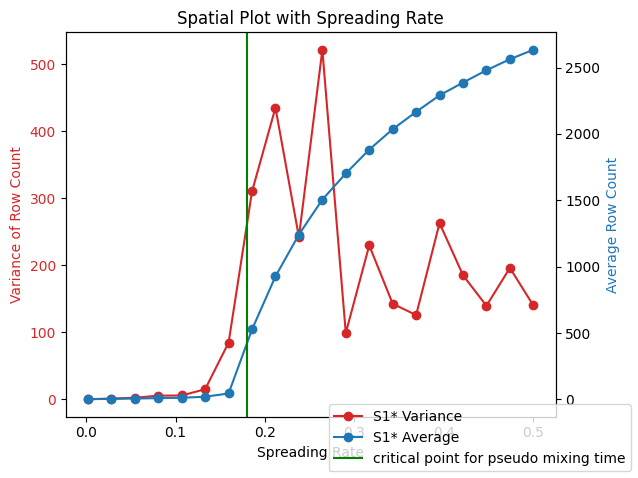

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Variance of Row Count', color=color)
ax1.plot(b, s1starvar, color=color, marker = 'o', label= 'S1* Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(b, s1staravg, color=color, marker = 'o', label= 'S1* Average')
ax2.set_ylabel('Average Row Count', color=color)
plt.axvline(x=0.17985714285714288, color='g', label = 'critical point for pseudo mixing time')


fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [10]:
b = np.linspace(0.002, 0.3, 20)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = []
    maxs2 = []
    maxs3 = []
    for j in range(20):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0)
        max_s1 = np.argmax(spatial1)
        maxs1.append(spatial1[max_s1])
        max_s2 = np.argmax(spatial2)
        maxs2.append(spatial2[max_s2])
        max_s3 = np.argmax(spatial3)
        maxs3.append(spatial3[max_s3])
    print(maxs1)
    s1.append(maxs1)
    s2.append(maxs2)
    s3.append(maxs3)

print(s1)
print(s2)
print(s3)


[2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2]
[4, 4, 3, 3, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 3, 3, 4, 5]
[5, 6, 6, 5, 4, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 6, 4]
[7, 5, 7, 5, 8, 6, 6, 8, 8, 8, 6, 6, 6, 5, 7, 5, 7, 6, 6, 7]
[8, 9, 6, 8, 9, 9, 9, 8, 7, 9, 8, 9, 7, 9, 6, 7, 9, 11, 6, 7]
[9, 11, 9, 9, 9, 10, 9, 9, 10, 10, 11, 7, 7, 9, 11, 9, 9, 8, 12, 14]
[14, 10, 8, 14, 12, 11, 11, 9, 10, 19, 11, 11, 9, 13, 9, 10, 10, 10, 12, 11]
[20, 11, 16, 15, 14, 12, 12, 14, 14, 13, 28, 16, 12, 12, 18, 10, 14, 20, 13, 14]
[17, 17, 16, 18, 15, 28, 18, 19, 17, 13, 19, 30, 21, 16, 19, 14, 15, 14, 18, 16]
[30, 19, 21, 26, 33, 19, 31, 23, 22, 27, 22, 23, 45, 22, 35, 27, 16, 20, 25, 28]
[51, 40, 58, 95, 39, 43, 91, 24, 33, 62, 82, 37, 39, 74, 31, 47, 23, 52, 33, 63]
[310, 301, 293, 168, 362, 276, 325, 295, 314, 322, 335, 237, 308, 313, 339, 337, 353, 317, 286, 343]
[629, 611, 615, 648, 605, 634, 632, 611, 605, 577, 572, 604, 621, 612, 606, 636, 600, 584, 624, 593]
[897, 837, 827, 846, 8

In [11]:
s1star = [[2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2], [4, 4, 3, 3, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 3, 3, 4, 5], [5, 6, 6, 5, 4, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 6, 4], [7, 5, 7, 5, 8, 6, 6, 8, 8, 8, 6, 6, 6, 5, 7, 5, 7, 6, 6, 7], [8, 9, 6, 8, 9, 9, 9, 8, 7, 9, 8, 9, 7, 9, 6, 7, 9, 11, 6, 7], [9, 11, 9, 9, 9, 10, 9, 9, 10, 10, 11, 7, 7, 9, 11, 9, 9, 8, 12, 14], [14, 10, 8, 14, 12, 11, 11, 9, 10, 19, 11, 11, 9, 13, 9, 10, 10, 10, 12, 11], [20, 11, 16, 15, 14, 12, 12, 14, 14, 13, 28, 16, 12, 12, 18, 10, 14, 20, 13, 14], [17, 17, 16, 18, 15, 28, 18, 19, 17, 13, 19, 30, 21, 16, 19, 14, 15, 14, 18, 16], [30, 19, 21, 26, 33, 19, 31, 23, 22, 27, 22, 23, 45, 22, 35, 27, 16, 20, 25, 28], [51, 40, 58, 95, 39, 43, 91, 24, 33, 62, 82, 37, 39, 74, 31, 47, 23, 52, 33, 63], [310, 301, 293, 168, 362, 276, 325, 295, 314, 322, 335, 237, 308, 313, 339, 337, 353, 317, 286, 343], [629, 611, 615, 648, 605, 634, 632, 611, 605, 577, 572, 604, 621, 612, 606, 636, 600, 584, 624, 593], [897, 837, 827, 846, 837, 847, 837, 854, 823, 912, 836, 851, 896, 844, 832, 841, 868, 843, 846, 843], [1047, 1081, 1054, 1047, 1032, 1086, 1045, 1052, 1059, 1043, 1072, 1055, 1065, 1045, 1034, 1057, 1023, 1074, 1023, 1083], [1220, 1233, 1236, 1205, 1250, 1210, 1201, 1222, 1228, 1254, 1221, 1249, 1243, 1214, 1257, 1259, 1221, 1241, 1211, 1218], [1402, 1384, 1385, 1398, 1379, 1393, 1369, 1389, 1383, 1409, 1393, 1381, 1394, 1388, 1412, 1371, 1380, 1390, 1388, 1382], [1569, 1558, 1553, 1547, 1538, 1556, 1549, 1503, 1517, 1522, 1542, 1543, 1536, 1530, 1551, 1531, 1549, 1531, 1553, 1520], [1666, 1692, 1649, 1643, 1669, 1651, 1660, 1636, 1676, 1700, 1649, 1653, 1652, 1658, 1668, 1663, 1638, 1686, 1641, 1652], [1803, 1751, 1768, 1769, 1759, 1783, 1758, 1761, 1764, 1748, 1774, 1777, 1796, 1776, 1759, 1768, 1773, 1763, 1789, 1795]]
s1starvar = [np.var(s1star[i]) for i in range(len(s1star))]
s1staravg = [np.mean(s1star[i]) for i in range(len(s1star))]
b = np.linspace(0.002, 0.3, 20)

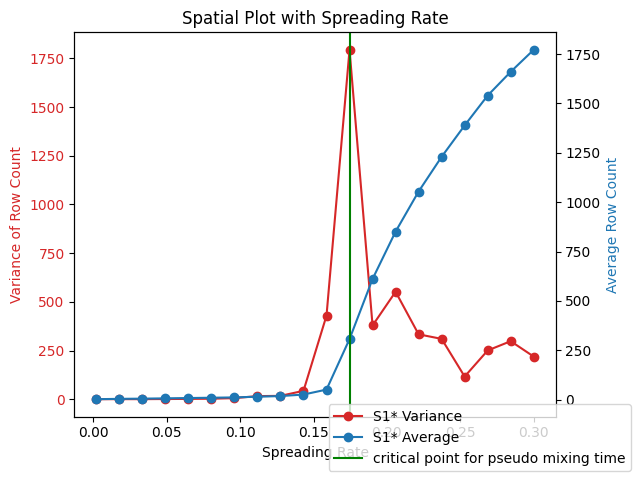

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Variance of Row Count', color=color)
ax1.plot(b, s1starvar, color=color, marker = 'o', label= 'S1* Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(b, s1staravg, color=color, marker = 'o', label= 'S1* Average')
ax2.set_ylabel('Average Row Count', color=color)
plt.axvline(x=0.1745263157894737, color='g', label = 'critical point for pseudo mixing time')


fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
